# Using MarkovModels.jl

This notebook shows how to use the [MarkovModels.jl](https://github.com/lucasondel/MarkovModels.jl) package to compute the forward-backward algorithm. 
This is down in three steps:
1. creating the inference graph, i.e. the markov chain of the model
2. compiling the graph into a suitable format
3. running the forward-backward algorithm


In [1]:
using Pkg
Pkg.activate("../")

using Plots
using SparseArrays

using Revise
using MarkovModels

  Activating environment at `~/Repositories/MarkovModels.jl/Project.toml`
┌ Info: Precompiling MarkovModels [c2ae6250-d0a1-11ea-0991-234599ce5244]
└ @ Base loading.jl:1317


## Inference graph

The first thing is to define the computation type. MarkovModels.jl does its computation in the logarithmic semifield and we have to specify the floating point precision:

In [3]:
T = Float64
SF = LogSemifield{T} 

LogSemifield{Float64}

In [96]:
exp(-0.105)# + exp(-0.642)

0.9003245225862656

Now, we create the inference graph:

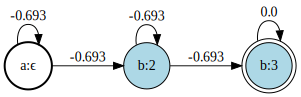

In [155]:
fsm = FSM{SF}()
S = 3 # Number of states

labels = ["a", "b", "c"]

prev = addstate!(fsm, label = labels[1])
link!(fsm, prev, prev)
setinit!(prev)
for s in 2:S
    state = addstate!(fsm, pdfindex = s, label = "$(labels[2])")
    link!(fsm, prev, state)
    link!(fsm, state, state)
    prev = state
end
setfinal!(prev)

fsm |> renormalize!

## Compilation

The second step is to compile the graph, to put it in an inference-easy format. Notice that by default, the vector/matrices are sparse. If you want to use dense matrices use `compile(fsm, allocator = zeros)`

In [222]:
cfsm = compile(fsm, allocator = zeros)

(π = LogSemifield{Float64}[0.0, -Inf, -Inf], ω = LogSemifield{Float64}[-Inf, -Inf, 0.0], A = LogSemifield{Float64}[-0.6931471805599453 -0.6931471805599453 -Inf; -Inf -0.6931471805599453 -0.6931471805599453; -Inf -Inf 0.0], Aᵀ = LogSemifield{Float64}[-0.6931471805599453 -Inf -Inf; -0.6931471805599453 -0.6931471805599453 -Inf; -Inf -0.6931471805599453 0.0], dists = [2, 1, 0], pdfmap = Union{Nothing, Int64}[nothing, 2, 3])

Just for information, the compiled graph `cfsm` has, among others, the following attributes:
* `cfsm.π` log-probability of the initial state
* `cfsm.ω` log-probability of the final state
* `cfsm.A` log-probability of the state transitions

However, you don't need to use them directly in most cases.

## Forward-Backward algorithm
 
For the sake of the example, we simulate some pseudo-loglikelihood:

In [178]:
S = length(cfsm.π) # number of states
N = 10 # number of frames
lhs = convert(Matrix{SF}, randn(T, S, N))

3×10 Matrix{LogSemifield{Float64}}:
 -0.295677  -1.08946   1.24333  0.399272  …   0.760757    1.30191   -0.759781
  0.181426  0.370999  0.210202   1.83318      0.434033  0.0695656  -0.0270109
   1.28046  -2.63098  0.150565   -1.8845     -0.890236   0.704565    0.487594

Notice that the matrix of log-likelihood has to be in the log-semifield!!

Now to compute the forward-backward algorithm we just have to do:

In [179]:
lnγ, ttl = αβrecursion(cfsm, lhs)

(LogSemifield{Float64}[0.0 -0.16550712313482596 … -Inf -Inf; -Inf -1.8803535083370582 … -2.5351767165295103 -Inf; -Inf -Inf … -0.08256424051731237 0.0], 0.9588332769748178)

where `lnγ` is a matrix of log-probability and `ttl` is the total log-probability of sequence.

To get the probability we need to convert `lnγ` to the natural semifield and take the element-wise exponential: 

In [180]:
γ = exp.(convert(Matrix{T}, lnγ))

3×10 Matrix{Float64}:
 1.0  0.847464  0.544992     0.275555   …  0.00769775  0.0        0.0
 0.0  0.152536  0.454787     0.701404      0.227412    0.0792477  0.0
 0.0  0.0       0.000220961  0.0230404     0.764891    0.920752   1.0

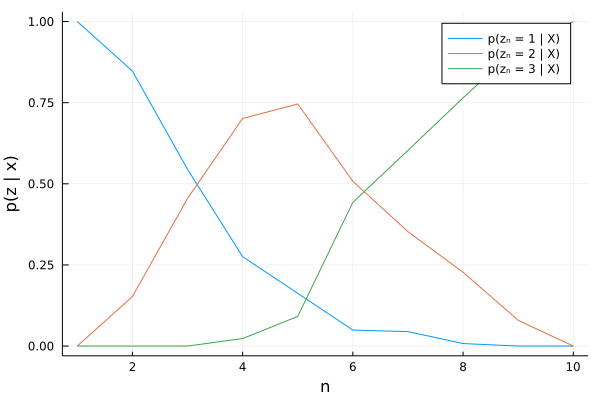

In [181]:
p = plot(xlabel = "n", ylabel = "p(z | x)")
for s in 1:S
    plot!(p, γ[s, :], label = "p(zₙ = $s | X)")
end
p

In [191]:
X = randn(3, 10)
B = randn(3, 3)


3×3 Matrix{Float64}:
 -0.165245  -0.531379   0.0848304
  1.58471   -0.771083  -0.0306343
 -0.967241   0.969113  -1.38927

In [184]:
using LogExpFunctions

3×1 Matrix{Float64}:
 2.773112840994104
 3.1363789736678873
 2.738799782817434

In [233]:
B = log.(Float64[
    1/2 1/2 0;
      0 1/2 1/2;
      0   0  1
])

v = log.(Float64[1, 0, 0])

3-element Vector{Float64}:
   0.0
 -Inf
 -Inf

In [263]:
zeros(3) + dropdims(logsumexp(transpose(B) .+ reshape(v, 1, :), dims=2), dims = 2)

3-element Vector{Float64}:
  -0.6931471805599453
  -0.6931471805599453
 -Inf

In [247]:
B .+ reshape(v, (:, 1))

3×3 Matrix{Float64}:
  -0.693147   -0.693147  -Inf
 -Inf        -Inf        -Inf
 -Inf        -Inf        -Inf

In [228]:
X[:, 2] = dropdims(logsumexp(B .+ X[:, 2], dims = 2), dims = 2)# + X[:, 1]

3-element Vector{Float64}:
 -0.8122664459858577
  3.430784870969541
 -0.48859252178566526

In [229]:
X[:,2]

3-element Vector{Float64}:
 -0.8122664459858577
  3.430784870969541
 -0.48859252178566526

In [220]:
sum(exp.(X .- logsumexp(X, dims = 1)))

9.999999999999998

In [223]:
cfsm.ω

3-element Vector{LogSemifield{Float64}}:
 -Inf
 -Inf
  0.0